In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import scipy.stats
import warnings
from matplotlib.patches import Patch
from plot_utils import *

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
root_dir = Path(f'/path/to/results/dir/vary_group_weight_with_seeds/')
force_reload = False

In [3]:
if force_reload or not Path('vary_group_weight_with_seeds_res.pkl').is_file():
    import os
    import sys
    sys.path.append('../')
    from auc_biases.hparams_registry import random_hparams, default_hparams, seed_hash
    
    results = []
    for i in tqdm(root_dir.glob('**/done')):
        args = json.load((i.parent/'args.json').open('r'))
        final_res = pickle.load((i.parent/'final_results.pkl').open('rb')) 
        # add back hparams
        if args['hparams_seed'] == 0:
            args['hparams'] = default_hparams(args['algorithm'], args['dataset'])
        else:
            args['hparams'] = random_hparams(args['algorithm'], args['dataset'], seed_hash(args['hparams_seed']))

        for attr in final_res:
            args_attr = copy.deepcopy(args)
            args_attr['attr'] = attr
            row = flatten_individual_res(final_res[attr])
            results.append({**args_attr, **row})   
    df_all = pd.DataFrame(results)
    df_all.to_pickle('vary_group_weight_with_seeds_res.pkl')

df_all = pd.read_pickle('vary_group_weight_with_seeds_res.pkl')

In [4]:
df_all.loc[(df_all.attr.str.lower().isin(['gender', 'male'])), 'attr'] = 'sex'

## Across Seeds

In [ ]:
df = df_all.copy()

In [8]:
assert len(df.seed.unique()) > 1
n_seeds = len(df.seed.unique())

In [9]:
cand_metrics = ['va_overall_AUROC', 'va_overall_AUPRC']

eval_metrics = ['te_overall_AUROC', 'te_overall_AUPRC', 
                'te_max_gap_AUROC', 'te_max_gap_AUPRC', 
               'te_signed_gap_AUROC', 'te_signed_gap_AUPRC']

prev_gap = df.groupby(['dataset', 'attr']).agg({'te_ratio_prevalence_50': 'first'})['te_ratio_prevalence_50']

In [10]:
indices = df.groupby(['dataset', 'attr', 'seed']).size().index
corr_df = []

for idx in indices:
    sub_df = df.set_index(['dataset', 'attr', 'seed']).loc[idx]
    if len(sub_df) < 10:
        continue
    for cand_metric in cand_metrics:
        for eval_metric in eval_metrics:
            if pd.isnull(sub_df[eval_metric]).sum() > 0:
                continue
            r = scipy.stats.spearmanr(sub_df[cand_metric], sub_df[eval_metric])[0]       
            corr_df.append({
                'dataset': idx[0],
                'attr': idx[1],
                'seed': idx[2],
                'select_metric': cand_metric,
                'eval_metric': eval_metric,
                'r': r,
                'n': len(sub_df)
            })
corr_df = pd.DataFrame(corr_df).dropna().set_index(['dataset', 'attr', 'seed'])

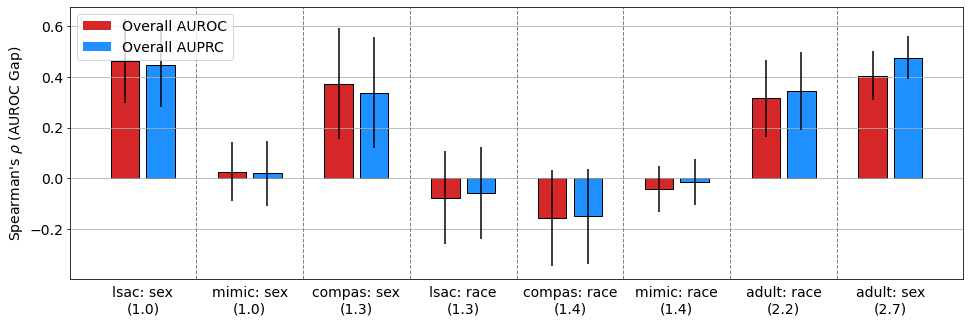

In [11]:
## bar plot showing raw spearman rho values (two bars per dataset)
y_var = 'te_signed_gap_AUROC'

pivot_corr_df = corr_df.pivot_table(values = ['r'], index = ['dataset', 'attr', 'seed', 'select_metric'], columns = ['eval_metric'])
pivot_corr_df.columns = [i[1] for i in pivot_corr_df.columns]
pivot_corr_df = pivot_corr_df.groupby(['dataset', 'attr', 'select_metric']).agg({y_var: ['mean', 'std']})

pivot_corr_df.columns = [i[1] for i in pivot_corr_df.columns]
pivot_corr_df['lower'] = pivot_corr_df['mean'] - 1.96 * pivot_corr_df['std'] /np.sqrt(n_seeds) 
pivot_corr_df['upper'] = pivot_corr_df['mean'] + 1.96 * pivot_corr_df['std'] /np.sqrt(n_seeds) 

auroc_df = pivot_corr_df.loc[pd.IndexSlice[:, :, 'va_overall_AUROC'], :].droplevel(2)
auprc_df = pivot_corr_df.loc[pd.IndexSlice[:, :, 'va_overall_AUPRC'], :].droplevel(2)

f = make_heatmap('val', 'Spearman\'s $\\rho$ (AUROC Gap)', 
                 auroc_df.rename(columns = {'mean': 'val'}), 
                 auprc_df.rename(columns = {'mean': 'val'}), 
                 prev_gap, 'Overall AUROC', 'Overall AUPRC', True,
                 auroc_df[['lower']].rename(columns = {'lower': 'val'}), 
                 auroc_df[['upper']].rename(columns = {'upper': 'val'}), 
                 auprc_df[['lower']].rename(columns = {'lower': 'val'}), 
                 auprc_df[['upper']].rename(columns = {'upper': 'val'}),  
                 subset_idx = None)
f.savefig('spearman_r_AUROC_20_seeds.pdf', bbox_inches = 'tight')

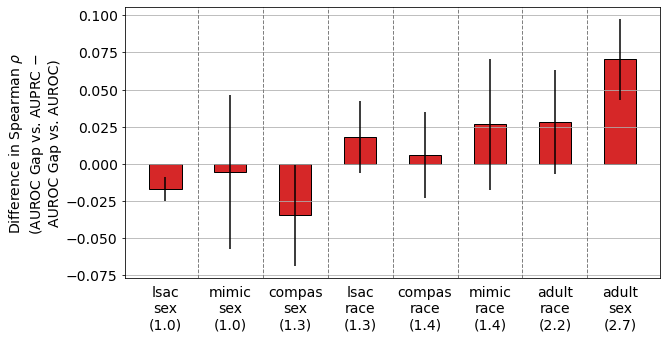

In [12]:
## bar plot showing spearman rho of AUPRC selection - spearman rho of AUROC selection
y_var = 'te_signed_gap_AUROC'

def apply_func(x):    
    dataset, attr, seed = x.index[0]
    x = x.reset_index().set_index(['select_metric', 'eval_metric'])
    r1 = x.loc[('va_overall_AUPRC', y_var), 'r']
    r2 = x.loc[('va_overall_AUROC', y_var), 'r']
    return r1 - r2

corr_df = corr_df.groupby(['dataset', 'attr', 'seed']).apply(apply_func).to_frame().groupby(['dataset', 'attr']).agg({0: ['mean', 'std']})
corr_df.columns = [i[1] for i in corr_df.columns]
corr_df['diff'] = corr_df['mean']
corr_df['lower'] = corr_df['mean'] - 1.96 * corr_df['std']/np.sqrt(n_seeds)
corr_df['upper'] = corr_df['mean'] + 1.96 * corr_df['std']/np.sqrt(n_seeds)

f = make_heatmap_single(corr_df, prev_gap, True, {'width': 1})
f.savefig('spearman_r_diff_AUROC_20_seeds.pdf', bbox_inches = 'tight')
plt.show()

In [24]:
corr_df.loc[prev_gap.sort_values(ascending = True).index]

mean       std      diff     lower     upper
dataset attr                                                   
lsac    sex   -0.016874  0.018173 -0.016874 -0.024838 -0.008909
mimic   sex   -0.005467  0.118061 -0.005467 -0.057210  0.046275
compas  sex   -0.034751  0.077613 -0.034751 -0.068767 -0.000736
lsac    race1  0.018335  0.055195  0.018335 -0.005855  0.042525
compas  race   0.005988  0.066330  0.005988 -0.023082  0.035059
mimic   Race   0.026592  0.100510  0.026592 -0.017459  0.070642
adult   Race   0.028174  0.080038  0.028174 -0.006904  0.063252
        sex    0.070249  0.062137  0.070249  0.043016  0.097482

In [25]:
prev_gap.sort_values(ascending = True).to_frame()

te_ratio_prevalence_50
dataset attr                         
lsac    sex                  1.000023
mimic   sex                  1.034483
compas  sex                  1.264000
lsac    race1                1.270611
compas  race                 1.422170
mimic   Race                 1.434783
adult   Race                 2.182796
        sex                  2.721497

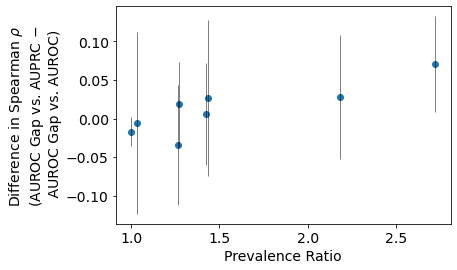

In [13]:
f = plt.figure()
plt.scatter(prev_gap.values, corr_df['mean'].values)
plt.errorbar(prev_gap.values, corr_df['mean'].values, yerr = corr_df['std'], ecolor = 'k', ls = 'none', linewidth = 0.5)
plt.xlabel("Prevalence Ratio")
plt.ylabel("Difference in Spearman $\\rho$\n(AUROC Gap vs. AUPRC $-$ \n AUROC Gap vs. AUROC)")
f.savefig('spearman_vs_prev_ratio_20_seeds.pdf', bbox_inches = 'tight')
plt.show()

In [14]:
scipy.stats.spearmanr(prev_gap.values, corr_df['mean'].values)

SignificanceResult(statistic=0.9047619047619048, pvalue=0.0020082755054294677)